In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.optimize import curve_fit

sns.set_style('whitegrid')

# **1.molecular dynamic**

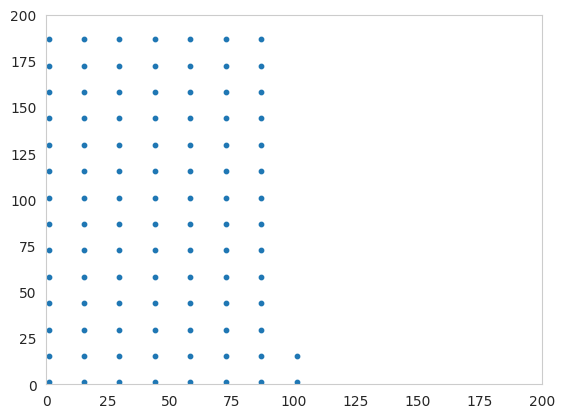

In [6]:
N = 100
L = 200
r = 1 #sigma in lennard-jones intraction
def initial_positions(N = 100):
  positions = np.zeros((N,2),dtype=float)

  #now lets fix initial positions.
  ncols = np.floor(np.sqrt(N/2))
  nrows = 2 * ncols
  a = L / (2 * ncols)#distance between atoms

  for n in range(N):
   positions[n, 0] = r + n // nrows * a
   positions[n, 1] = r + n % nrows * a
  return positions

positions = initial_positions()
plt.scatter(positions[:,0], positions[:, 1], s = 10)
plt.xlim(0,200)
plt.ylim(0,200)
plt.grid(False)
plt.show()

In [7]:
#now i will set initial velocities based on total energy of particles E
def initial_vel(E,m=1, N=100):
  np.random.seed(7)
  vavg = (2 * E / (m * N)) ** 0.5
  vmax = 2 * vavg
  v = np.random.randn(N) * vmax
  theta = np.random.randn(N) * 2 * np.pi
  velocities = np.c_[v * np.cos(theta), v * np.sin(theta)]
  velocities -= np.mean(velocities, axis=0)#setting CM's velocity to 0
  return velocities

velocities = initial_vel(1000)
velocities

array([[  8.91718422,  11.47851652],
       [  1.88936589,  -2.85402051],
       [ -1.27379204,   0.28937332],
       [ -4.46043987,  -1.17060415],
       [  5.9845501 ,  -0.50064137],
       [ -1.06254213,   0.11227223],
       [ -1.03866488,   0.10092285],
       [ -9.71656146, -12.97768202],
       [ -2.87872664,  -8.81128887],
       [ -6.23199991,  -1.29239285],
       [  0.2766266 ,   5.53991002],
       [ -0.57340922,  -1.35538515],
       [  3.19734688,   1.66070888],
       [  1.09440239,   1.04473281],
       [ -1.2701668 ,   2.2640513 ],
       [ -6.36489686, -11.75555758],
       [  3.86614651,   0.79549905],
       [ -2.04559189,  -0.3731716 ],
       [ -2.51226087,   2.07315407],
       [ -0.83796264,  13.75652996],
       [-12.44471317,  -9.27900931],
       [ -0.26328326,   1.24166196],
       [  1.20943315,   2.73202929],
       [ 11.3258742 ,  13.38273006],
       [ -1.4065519 ,   0.29060378],
       [ -3.58129064,  12.82958535],
       [  2.56941619,  -0.15435386],
 

In [8]:
#now i will write a function that will calculate acceleration of each particle with lennard-jones intractions
def lj(positions, N=100, e=1, L=200, m=1):
  a = np.zeros((N,2))
  for n in range(N):
    others = np.vstack((positions[0:n], positions[n+1 :]))
    delta = others - positions[n]
    delta = (delta + L/2) % L - L/2
    distance = (np.sum(delta ** 2, axis = 1) ** 0.5).reshape(-1,1)
    distance[distance < 0.85] = 0.85
    a[n] = np.sum(4 * e * (12 * delta / distance ** 14 - 6 * delta / distance ** 8), axis = 0) / m

  return a

a = lj(positions)
a

array([[-2.26399881e-07,  8.77499340e-13],
       [-2.26399881e-07,  9.40747441e-13],
       [-2.26399946e-07,  9.90845862e-13],
       [-2.26400045e-07,  1.01161886e-12],
       [-2.26400143e-07,  1.00581027e-12],
       [-2.26400219e-07,  9.86369696e-13],
       [-2.26400270e-07,  9.64798011e-13],
       [-2.26400301e-07,  9.46841547e-13],
       [-2.26400301e-07,  9.01405235e-13],
       [-2.26400270e-07, -9.64798014e-13],
       [-2.26400219e-07,  8.31877086e-13],
       [-2.26400143e-07,  8.12436510e-13],
       [-2.26400045e-07, -1.01161886e-12],
       [-2.26399946e-07,  8.27400918e-13],
       [-3.36318378e-09,  9.98526541e-13],
       [-3.36318378e-09,  1.20944793e-12],
       [-3.36294097e-09,  1.36386224e-12],
       [-3.36259740e-09,  1.40300169e-12],
       [-3.36229635e-09,  1.35671686e-12],
       [-3.36209280e-09,  1.28349206e-12],
       [-3.36197474e-09,  1.21949103e-12],
       [-3.36191181e-09,  1.17462021e-12],
       [-3.36191181e-09,  1.08636329e-12],
       [-3.

In [9]:
def energy(pos, vel, m=1, e=1, c=1, N=100):
  ke = 0.5 * m * np.sum(vel ** 2)
  pot = 0
  for n in range(N):
    others = np.vstack((pos[:n], pos[n+1:]))
    others = (others + L/2) % L - L / 2
    delta = np.sum((others - pos[n]) ** 2, axis=1)
    delta[delta<0.85] = 0.85
    pot += np.sum(4 * e * ((c ** 12 / delta ** 6) - (c ** 6 / delta ** 3)))

  return 0.5 * pot + ke

en = energy(positions, velocities)
en

np.float64(4096.672869219295)

In [10]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 2000
#now we have accelarations based on positions so i can go on and calculate dynamic of system in fixed intervals
def animation(E,frame=500, N=100, L=200, k=10, dt= 0.02):
  positions = initial_positions(N)
  velocities = initial_vel(E, N)
  n_left = pd.Series([100])
  En = pd.Series(energy(positions, velocities))
  velocities_all = np.zeros((frame, N, 2))
  positions_all = np.zeros((frame, N, 2))
  a = lj(positions)

  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,12))
  ax1.grid(False)
  ax2.set_title("the number of particles in the left side")
  ax1.set_xlim(0, 200)
  ax1.set_ylim(0, L)

  ax2.set_ylim(0, N)
  ax2.set_xlabel('time')

  ax3.set_ylim(0.5 * En[0] , 1.5 * En[0])
  ax2.set_title('Energy')
  ax3.set_xlabel('time')

  plot1 = ax1.scatter([], [], s = 20)
  plot2, = ax2.plot([], [])
  plot3, = ax3.plot([], [])
  T = 0
  t = [0]
  def update(frame, dt = dt, k=k):
    nonlocal positions, velocities, L, n_left, T, velocities_all, t, E, a, positions_all
    T = T + k * dt
    t.append(T)
    velocities_all[frame] = velocities.copy()
    positions_all[frame] = positions.copy()

    for _ in range(k):
      velocities += 0.5 * a * dt#i used velocity verlet
      positions = (positions + velocities * dt) % L
      a = lj(positions)
      velocities += 0.5 * a * dt


    n_left.loc[len(n_left)] = np.sum(positions[:, 0] < (L / 2))
    En.loc[len(En)] = energy(positions, velocities)

    plot1.set_offsets(positions)
    plot2.set_data(t, n_left)
    plot3.set_data(t, En)
    ax2.set_xlim(0, T)
    ax3.set_xlim(0, T)
    return plot1, plot2, plot3


  ani = FuncAnimation(fig,update,frames = frame, interval = 200, blit= True)
  return HTML(ani.to_jshtml()), velocities_all, positions_all

In [ ]:
E = [100000]
velocities_history = []
pos_history = []
for e in E:
  animation, vel, pos_all = animation(e)
  velocities_history.append(vel)
  pos_history.append(vel)
  display(animation)

In [ ]:
def VAC(velocities_all):
  T, N, m = velocities_all.shape
  vac = []
  v0 = velocities_all[0]
  for i in range(T):
    vi = velocities_all[i]
    dot = np.sum(v0 * vi, axis=1)
    vac.append(np.mean(dot))

  return vac / vac[0]

for i in range(len(E)):
  vac = VAC(velocities_history[i])
  t = np.arange(len(vac)) * 0.2
  plt.plot(t, vac)
  plt.title('Velocities Auto Correlation')
  plt.xlabel('time')
  plt.ylabel('VAC')
  plt.show()

In [ ]:
#in reduced units we have: T = Kenetic energy / degrees of freedom
def temp(velocities_history,N=100):
  T = []
  for i in range(len(velocities_history)):
    vel = velocities_history[i] ** 2
    T.append(np.sum(vel) / (2*N-2))
  return T

T = temp(velocities_history[0])
t = np.arange(len(velocities_history[0])) * 0.2
plt.plot(t,T)
plt.ylim(np.min(T) * 0.95, np.max(T) * 1.05)
plt.ylabel('Tempreture')
plt.xlabel('Time')
plt.show()

In [ ]:
def pressure(T, positions_all, N=100, L=200, e=1):
  P = []
  for i in range(len(positions_all)):
    positions = positions_all[i]
    F_r = 0
    for n in range(N):
      others = np.vstack((positions[0:n], positions[n+1 :]))
      delta = others - positions[n]
      delta = (delta + L/2) % L - L/2
      distance = (np.sum(delta ** 2, axis = 1) ** 0.5).reshape(-1,1)
      distance[distance < 0.85] = 0.85
      F_r += 0.5 * np.sum(4 * e * (12 * delta / distance ** 14 - 6 * delta / distance ** 8) * delta)
    P.append( N * T[i] / L**2 + 0.5 * F_r / L ** 2)

  return P

P = pressure(T, pos_history)
plt.plot(t, P)
plt.xlabel('time')
plt.ylabel('pressure')
plt.show()

In [ ]:
def defussion(positions_all, dt = 0.2, L=200):
  l = len(positions_all)
  D = []
  r0 = positions_all[0]
  for i in range(1, l):
    r = positions_all[i]
    D.append(1 / (4 * i * dt) * np.mean(np.sum((( (r - r0) + L/2 )%L - L/2) ** 2, axis = 1)))

  return D

plt.plot(t, D)
plt.xlabel('time')
plt.ylabel('difussion coeficient')
plt.show()

In [ ]:
def temp(vel, N=100):
  v = vel ** 2
  T = np.sum(v) / (2*N-2)

  return T


def pressure(T, pos, N=100, L=200, e=1):
    F_r = 0
    for n in range(N):
      others = np.vstack((pos[0:n], pos[n+1 :]))
      delta = others - pos[n]
      delta = (delta + L/2) % L - L/2
      distance = (np.sum(delta ** 2, axis = 1) ** 0.5).reshape(-1,1)
      distance[distance < 0.85] = 0.85
      F_r += 0.5 * np.sum(4 * e * (12 * delta / distance ** 14 - 6 * delta / distance ** 8) * delta)

    return (N * T / L**2 + 0.5 * F_r / L ** 2)




def md(E, dt=0.01, N=100, L=200, n=1e4):
  pos = initial_positions(N)
  vel = initial_vel(E, N)
  En = pd.Series(energy(pos, vel))
  vel_all = np.zeros((n, N, 2))
  pos_all = np.zeros((n, N, 2))
  a = lj(pos)
  T = [temp(vel)]
  P = [pressure(temp(vel), pos)]
  V = N / L ** 2#volume in reduced units

  for i in range(n):
      vel += 0.5 * a * dt
      pos = (pos + vel * dt) % L
      a = lj(pos)
      vel += 0.5 * a * dt
      vel_all[i] = vel
      pos_all[i] = pos
      T.append(temp(vel))
      P.append(pressure(temp(vel), pos))
  P = np.array(P)
  T = np.array(T)
  return P, T, V

E = np.arange(1, 100) * 1000
N = [100]

P = []
T = []
V = []

for e in E:
  for num in N:
    p, t, v = md(E=e, N=num)
    P.append(np.mean(p[-1000:]))
    T.append(np.mean(t[-1000:]))
    V.append(v)

V = np.array(V)
P = np.array(P)
T = np.array(T)

def van(T, V, a, b):
  return T / (V - b) - a / V ** 2

params, _ = curve_fit(van, [T, V], P)
a, b = params
a = a * 1.656 * 1e-21 * (3.4 * 1e-10) ** 3
b = b * (3.4 * 1e-10) ** 3
a *= Na**2
b *= Na
print(a, b)

In [ ]:
def phase_change_animation(E,frame=500, N=100, L=200, k=100, dt= 0.02, scale=0.9999):
  positions = initial_positions(N)
  velocities = initial_vel(E, N)
  n_left = pd.Series([100])
  En = pd.Series(energy(positions, velocities))
  velocities_all = np.zeros((frame, N, 2))
  positions_all = np.zeros((frame, N, 2))
  a = lj(positions)

  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,12))
  ax1.grid(False)
  ax2.set_title("the number of particles in the left side")
  ax1.set_xlim(0, 200)
  ax1.set_ylim(0, L)

  ax2.set_ylim(0, N)
  ax2.set_xlabel('time')

  ax3.set_ylim(0.5 * En[0] , 1.5 * En[0])
  ax2.set_title('Energy')
  ax3.set_xlabel('time')

  plot1 = ax1.scatter([], [], s = 20)
  plot2, = ax2.plot([], [])
  plot3, = ax3.plot([], [])
  T = 0
  t = [0]
  def update(frame, dt = dt, k=k):
    nonlocal positions, velocities, L, n_left, T, velocities_all, t, E, a, positions_all
    T = T + k * dt
    t.append(T)
    velocities_all[frame] = velocities.copy()
    positions_all[frame] = positions.copy()

    for _ in range(k):
      velocities += 0.5 * a * dt * scale#i used velocity verlet
      positions = (positions + velocities * dt) % L
      a = lj(positions)
      velocities += 0.5 * a * dt


    n_left.loc[len(n_left)] = np.sum(positions[:, 0] < (L / 2))
    En.loc[len(En)] = energy(positions, velocities)

    plot1.set_offsets(positions)
    plot2.set_data(t, n_left)
    plot3.set_data(t, En)
    ax2.set_xlim(0, T)
    ax3.set_xlim(0, T)
    return plot1, plot2, plot3


  ani = FuncAnimation(fig,update,frames = frame, interval = 200, blit= True)
  return HTML(ani.to_jshtml()), velocities_all, positions_all

In [ ]:
E = [100000]
velocities_history = []
pos_history = []
for e in E:
  animation, vel, pos_all = animation(e)
  velocities_history.append(vel)
  pos_history.append(vel)
  display(animation)